In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold

data = pd.read_csv('train.csv')

In [3]:
data = np.array(data)
m, n = data.shape
np.random.shuffle(data) 

In [4]:
X, y = data[:1000,1:], data[:1000,0]

In [5]:
X = X / 255.

In [6]:
size = 0.3
test_size = int(size * len(X))
X_train, X_test = X[:test_size], X[test_size:]
y_train, y_test = y[:test_size], y[test_size:]

In [9]:
X_train.shape

(300, 784)

In [10]:
X_test.shape

(700, 784)

In [11]:
X_test = X_test.T

In [19]:
class MLP_MNIST:
    
    def __init__(self,sizes,epoch, alpha = 0.1,eta = 0.1, rho = ):
        
        self.sizes = sizes
        self.epoch = epoch
        self.eta = eta
        self.error= []
        self.alpha = alpha * 10
        
        self.input_layer = self.sizes[0]
        self.hidden_1 = self.sizes[1]
        self.hidden_2 = self.sizes[2]
        self.hidden_3 = self.sizes[3]
        self.output_layer = self.sizes[4]
        
        self.W1 = np.random.rand(self.hidden_1, self.input_layer) - 0.5
        self.b1 = np.random.rand(self.hidden_1, 1) - 0.5
        self.W2 = np.random.rand(self.hidden_2, self.hidden_1) - 0.5
        self.b2 = np.random.rand(self.hidden_2, 1) - 0.5
        self.W3 = np.random.rand(self.hidden_3, self.hidden_2) - 0.5
        self.b3 = np.random.rand(self.hidden_3, 1) - 0.5
        self.W4 = np.random.rand(self.output_layer, self.hidden_3) - 0.5
        self.b4 = np.random.rand(self.output_layer, 1) - 0.5
        
    def sigmoid(self, x, derivative=False):
        if derivative:
            return (np.exp(-x))/((np.exp(-x)+1)**2)
        return 1/(1 + np.exp(-x))
    
    def ReLU(self, x, derivative = False):
        if derivative:
            return (x > 0).astype(int)
        return np.maximum(x, 0)
    
    def forward_prop(self, X):
        
        self.A0 = X
        self.Z1 = np.dot(self.W1, self.A0) + self.b1
        self.A1 = self.ReLU(self.Z1)
        
        self.Z2 = np.dot(self.W2, self.A1) + self.b2
        self.A2 = self.ReLU(self.Z2)
        
        self.Z3 = np.dot(self.W3, self.A2) + self.b3
        self.A3 = self.sigmoid(self.Z3)
        
        self.Z4 = np.dot(self.W4, self.A3) + self.b4
        self.A4 = self.sigmoid(self.Z4)
        return self.A4
    
    def one_hot(self,Y):
        one_hot_Y = np.zeros((Y.size, 10))
        one_hot_Y[np.arange(Y.size), Y] = 1
        one_hot_Y = one_hot_Y.T
        return one_hot_Y
    
    def backward_prop(self, y_train, output, start_id, end_id):
        
        one_hot_y = self.one_hot(y_train)
        one_hot_y = one_hot_y[:,start_id:end_id]
        
        self.dA4 = output - one_hot_y
        self.dZ4 = np.multiply(self.sigmoid(self.Z4,derivative=True), self.dA4)
        self.dW4 = 1/self.dZ4.shape[1] * np.dot(self.dZ4, self.A3.T)
        self.db4 = 1/self.dZ4.shape[1] * np.sum(self.dZ4, axis=1, keepdims=True)
        
        self.dA3 = np.dot(self.W4.T, self.dZ4)
        self.dZ3 = np.multiply(self.sigmoid(self.Z3,derivative=True), self.dA3)
        self.dW3 = 1/self.dZ3.shape[1] * np.dot(self.dZ3, self.A2.T)
        self.db3 = 1/self.dZ3.shape[1] * np.sum(self.dZ3, axis=1, keepdims=True)
        
        self.dA2 = np.dot(self.W3.T, self.dZ3)
        self.dZ2 = np.multiply(self.ReLU(self.Z2,derivative=True), self.dA2)
        self.dW2 = 1/self.dZ2.shape[1] * np.dot(self.dZ2, self.A1.T)
        self.db2 = 1/self.dZ2.shape[1] * np.sum(self.dZ2, axis=1, keepdims=True)
        
        self.dA1 = np.dot(self.W2.T, self.dZ2)
        self.dZ1 = np.multiply(self.ReLU(self.Z1,derivative=True), self.dA1)
        self.dW1 = 1/self.dZ1.shape[1] * np.dot(self.dZ1, self.A0.T)
        self.db1 = 1/self.dZ1.shape[1] * np.sum(self.dZ1, axis=1, keepdims=True)
        
        self.W4 = self.alpha * self.W4 - self.eta * self.dW4
        self.b4 = self.alpha * self.b4 - self.eta * self.db4
        self.W3 = self.alpha * self.W3 - self.eta * self.dW3
        self.b3 = self.alpha * self.b3 - self.eta * self.db3
        self.W2 = self.alpha * self.W2 - self.eta * self.dW2
        self.b2 = self.alpha * self.b2 - self.eta * self.db2
        self.W1 = self.alpha * self.W1 - self.eta * self.dW1
        self.b1 = self.alpha * self.b1 - self.eta * self.db1
    
    def train(self, X, y, batch_size):
        
        self.batch_size = batch_size
        for iteration in range(self.epoch):
            
            m = 0
            accuracy = 0
            kf = KFold(n_splits=10)
            for train_index, test_index in kf.split(X, y):
                
                x_train, x_test = X[train_index,:], X[test_index,:]
                y_train, y_test = y[train_index],y[test_index]
                
                x_train = x_train.T
                x_test = x_test.T
                self.batch_size = min(self.batch_size, x_train.shape[1])
                start_id, end_id = 0, self.batch_size
                while end_id <= x_train.shape[1]:

                    x = x_train[:,start_id: end_id]
                    output = self.forward_prop(x)
                    m += 1 / self.batch_size * np.sum(np.argmax(output, 0) != y_train[start_id: end_id])
                    self.backward_prop(y_train, output,start_id, end_id)

                    start_id = end_id
                    end_id = end_id + self.batch_size
                
                accuracy += self.get_accuracy(x_test, y_test)
            
            
            print('Cross-Val Accuracy at {}th iteration: {}'.format(iteration + 1, accuracy * 10))
            self.error.append(m)
    
    def predict(self,X):
        
        predictions = []
        
        output = self.forward_prop(X)
        #print(output)
        return np.argmax(output, 0)
    
    def confusion_matrix(self, y, y_pred):
        
        classes = np.unique(y)
        conf_mat = np.zeros((len(classes), len(classes)))
        for a, p in zip(y, y_pred):
            conf_mat[a][p] += 1
        print(conf_mat)
    
    def error_iteration_curve(self):
        
        import seaborn as sns
        sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
        fig = plt.figure(figsize=(20,9))
        plt.xlabel('Epoch')
        plt.ylabel('Error')
        plt.plot(self.error,'r--')
        plt.show()
        
    
    def get_accuracy(self, X, y):
        output = np.argmax(self.forward_prop(X), 0)
        return np.sum(output == y) / y.size

## Stochastic Learning

In [20]:
#stochastic
model1 = MLP_MNIST([784, 196, 49, 10, 10], 5)
model1.train(X_train, y_train, 1)

Cross-Val Accuracy at 1th iteration: 52.333333333333336
Cross-Val Accuracy at 2th iteration: 82.00000000000001
Cross-Val Accuracy at 3th iteration: 91.66666666666669
Cross-Val Accuracy at 4th iteration: 93.0
Cross-Val Accuracy at 5th iteration: 91.33333333333334


In [21]:
y_pred_train_1 = model1.predict(X_train.T)
model1.confusion_matrix(y_train, y_pred_train_1)

[[27.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. 37.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. 40.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. 35.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. 23.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  2.  0. 19.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. 30.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0. 26.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0. 25.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  2.  0. 30.]]


In [22]:
y_pred_test_1 = model1.predict(X_test)
model1.confusion_matrix(y_test, y_pred_test_1)

[[67.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0. 58.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  1. 53.  5.  0.  1.  1.  2.  3.  0.]
 [ 0.  1.  0. 67.  0. 11.  0.  2.  1.  0.]
 [ 0.  4.  1.  0. 60.  0.  0.  4.  3. 15.]
 [ 0.  6.  0. 12.  3. 33.  0.  8.  2.  3.]
 [ 3.  1.  5.  0.  1.  0. 56.  0.  3.  1.]
 [ 0.  0.  4.  2.  0.  2.  0. 53.  2. 10.]
 [ 1.  8.  3.  6.  3.  3.  1.  6. 21.  5.]
 [ 1.  0.  0.  1.  6.  2.  1. 12.  0. 48.]]


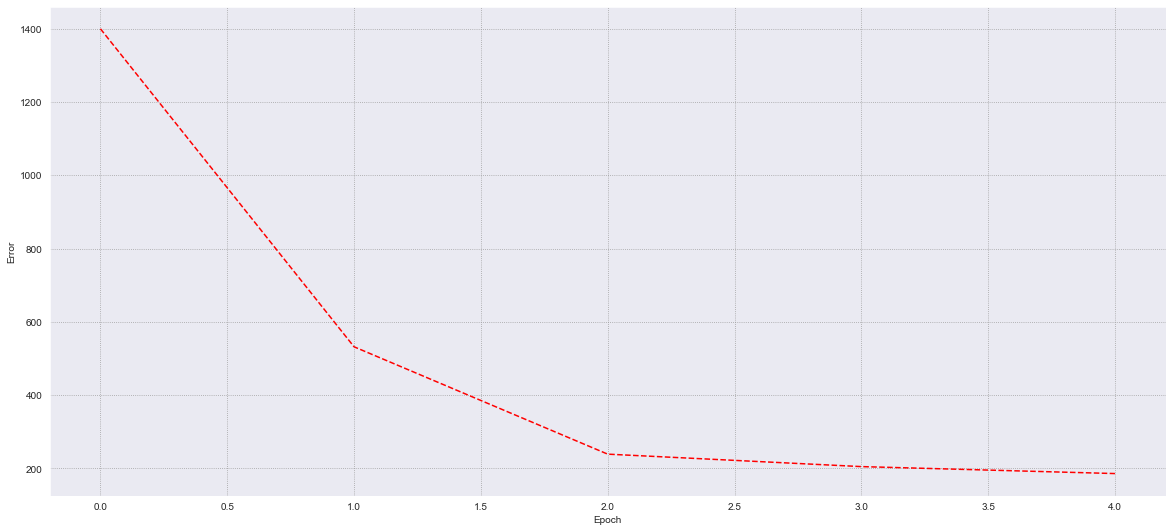

In [23]:
model1.error_iteration_curve()

## Batch Learning

In [25]:
#batch
model2 = MLP_MNIST([784, 196, 49, 10, 10], 250)
model2.train(X_train, y_train, X_train.shape[0])

Cross-Val Accuracy at 1th iteration: 9.999999999999998
Cross-Val Accuracy at 2th iteration: 9.0
Cross-Val Accuracy at 3th iteration: 9.333333333333334
Cross-Val Accuracy at 4th iteration: 9.666666666666666
Cross-Val Accuracy at 5th iteration: 10.666666666666666
Cross-Val Accuracy at 6th iteration: 12.0
Cross-Val Accuracy at 7th iteration: 13.666666666666664
Cross-Val Accuracy at 8th iteration: 13.666666666666664
Cross-Val Accuracy at 9th iteration: 12.333333333333334
Cross-Val Accuracy at 10th iteration: 13.333333333333332
Cross-Val Accuracy at 11th iteration: 15.333333333333334
Cross-Val Accuracy at 12th iteration: 16.333333333333336
Cross-Val Accuracy at 13th iteration: 16.666666666666668
Cross-Val Accuracy at 14th iteration: 16.666666666666668
Cross-Val Accuracy at 15th iteration: 17.0
Cross-Val Accuracy at 16th iteration: 17.333333333333336
Cross-Val Accuracy at 17th iteration: 16.666666666666668
Cross-Val Accuracy at 18th iteration: 16.333333333333332
Cross-Val Accuracy at 19th it

Cross-Val Accuracy at 154th iteration: 53.00000000000001
Cross-Val Accuracy at 155th iteration: 53.00000000000001
Cross-Val Accuracy at 156th iteration: 53.00000000000001
Cross-Val Accuracy at 157th iteration: 53.33333333333334
Cross-Val Accuracy at 158th iteration: 53.33333333333334
Cross-Val Accuracy at 159th iteration: 53.33333333333334
Cross-Val Accuracy at 160th iteration: 53.33333333333334
Cross-Val Accuracy at 161th iteration: 53.66666666666667
Cross-Val Accuracy at 162th iteration: 54.0
Cross-Val Accuracy at 163th iteration: 54.0
Cross-Val Accuracy at 164th iteration: 54.0
Cross-Val Accuracy at 165th iteration: 54.333333333333336
Cross-Val Accuracy at 166th iteration: 54.333333333333336
Cross-Val Accuracy at 167th iteration: 55.00000000000001
Cross-Val Accuracy at 168th iteration: 55.00000000000001
Cross-Val Accuracy at 169th iteration: 55.33333333333334
Cross-Val Accuracy at 170th iteration: 55.33333333333334
Cross-Val Accuracy at 171th iteration: 55.66666666666667
Cross-Val A

In [26]:
y_pred_train_1 = model2.predict(X_train.T)
model2.confusion_matrix(y_train, y_pred_train_1)

[[ 5.  0.  0.  1.  0.  0. 21.  0.  0.  0.]
 [ 0. 36.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. 39.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0. 34.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  4.  0.  0.  0.  5.  1.  9.  4.]
 [ 0.  0.  1. 19.  0.  0.  2.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0. 30.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. 25.  0.  2.]
 [ 0.  1.  1.  5.  0.  0.  2.  0. 17.  0.]
 [ 0.  0.  1.  1.  0.  0.  1.  3.  0. 26.]]


In [27]:
y_pred_test_1 = model2.predict(X_test)
model2.confusion_matrix(y_test, y_pred_test_1)

[[ 7.  0.  2. 17.  0.  0. 41.  0.  1.  0.]
 [ 0. 55.  1.  0.  0.  0.  0.  0.  1.  1.]
 [ 0.  1. 52.  6.  0.  0.  4.  2.  2.  0.]
 [ 0.  4.  5. 60.  0.  0.  6.  1.  2.  4.]
 [ 2. 12.  9. 11.  0.  0. 10.  9.  7. 27.]
 [ 0.  0.  5. 45.  0.  0.  5.  4.  2.  6.]
 [ 1.  0. 11.  4.  0.  0. 52.  1.  1.  0.]
 [ 0.  6.  1.  0.  0.  0.  1. 60.  0.  5.]
 [ 1. 11. 14. 11.  1.  0.  7.  2.  8.  2.]
 [ 1.  8.  4.  0.  0.  0.  8. 15.  1. 34.]]


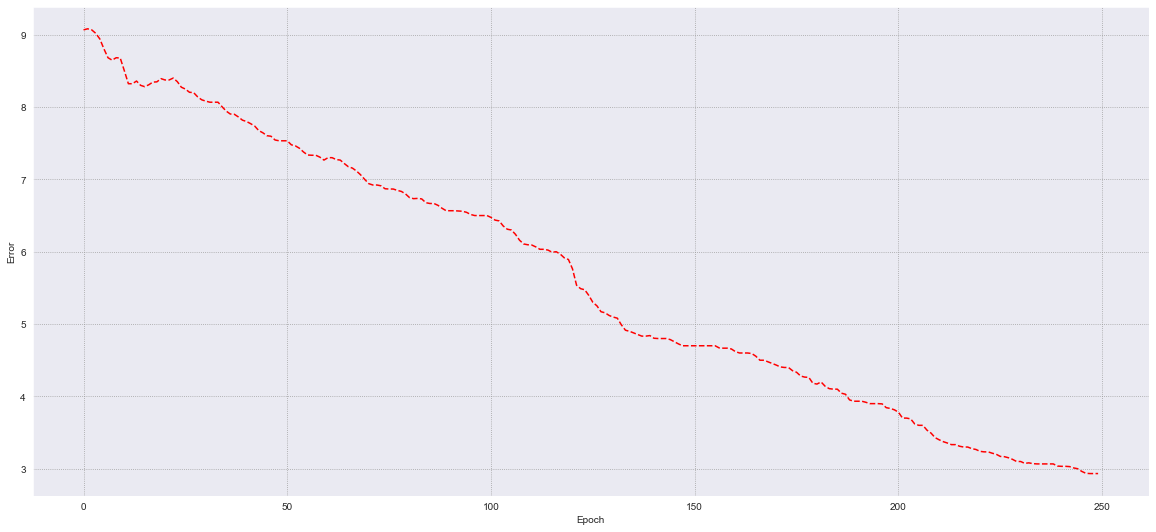

In [28]:
model2.error_iteration_curve()

## Mini-Batch Learning

In [29]:
#minibatch(batch_size = 50)
model3 = MLP_MNIST([784, 196, 49, 10, 10],100)
model3.train(X_train, y_train, 50)

Cross-Val Accuracy at 1th iteration: 14.999999999999998
Cross-Val Accuracy at 2th iteration: 21.666666666666664
Cross-Val Accuracy at 3th iteration: 22.33333333333333
Cross-Val Accuracy at 4th iteration: 23.333333333333336
Cross-Val Accuracy at 5th iteration: 26.333333333333332
Cross-Val Accuracy at 6th iteration: 27.666666666666664
Cross-Val Accuracy at 7th iteration: 29.66666666666667
Cross-Val Accuracy at 8th iteration: 30.666666666666668
Cross-Val Accuracy at 9th iteration: 32.666666666666664
Cross-Val Accuracy at 10th iteration: 34.33333333333333
Cross-Val Accuracy at 11th iteration: 34.99999999999999
Cross-Val Accuracy at 12th iteration: 35.666666666666664
Cross-Val Accuracy at 13th iteration: 36.666666666666664
Cross-Val Accuracy at 14th iteration: 38.333333333333336
Cross-Val Accuracy at 15th iteration: 39.33333333333333
Cross-Val Accuracy at 16th iteration: 40.33333333333334
Cross-Val Accuracy at 17th iteration: 41.00000000000001
Cross-Val Accuracy at 18th iteration: 42.666666

In [31]:
y_pred_train_1 = model3.predict(X_train.T)
model3.confusion_matrix(y_train, y_pred_train_1)

[[26.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0. 36.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0. 38.  0.  0.  0.  0.  0.  2.  0.]
 [ 0.  8.  0. 25.  1.  1.  0.  0.  0.  0.]
 [ 0.  0.  1.  0. 22.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0. 22.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. 30.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0. 25.  0.  1.]
 [ 0.  0.  1.  1.  1.  0.  0.  0. 23.  0.]
 [ 0.  0.  0.  0.  1.  0.  2.  2.  1. 26.]]


In [32]:
y_pred_test_1 = model3.predict(X_test)
model3.confusion_matrix(y_test, y_pred_test_1)

[[56.  1.  0.  0.  3.  0.  6.  0.  0.  2.]
 [ 0. 54.  0.  1.  0.  0.  0.  0.  3.  0.]
 [ 1.  6. 41.  3.  0.  1.  8.  0.  6.  1.]
 [ 2. 17.  3. 43.  1.  5.  1.  3.  7.  0.]
 [ 6.  4.  7.  0. 41.  1.  3.  2.  2. 21.]
 [18.  3.  2.  9.  5. 24.  0.  1.  4.  1.]
 [ 3.  0.  5.  0.  1.  9. 48.  0.  2.  2.]
 [ 1.  2.  5.  0.  1.  0.  0. 58.  1.  5.]
 [ 1. 15.  6.  0.  1.  6.  1.  1. 22.  4.]
 [ 7.  6.  3.  0.  7.  1.  0. 10.  4. 33.]]


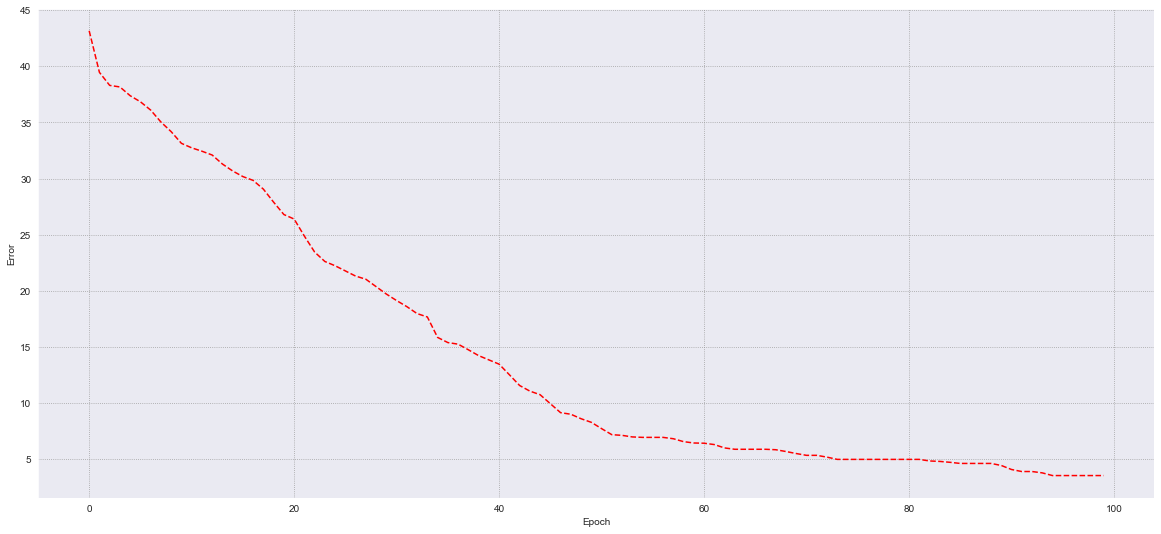

In [33]:
model3.error_iteration_curve()